In [230]:
import numpy as np
import scipy
import cv2
import matplotlib.pyplot as plt
from random import randint, uniform

ModuleNotFoundError: No module named 'cv2'

In [2]:
def compute_mean(sample):
    dimension = sample.shape[0]
    sum_vector = np.zeros((dimension,1))
    sum_vector = sum_vector.flatten('F') 
    
    for x in range(sample.shape[1]):
        sum_vector = sum_vector + sample[:,x].flatten('F')

    return (sum_vector/sample.shape[1]).T

In [3]:
def compute_cov(sample):
    mean = compute_mean(sample)
    dimension = sample.shape[0]
    err_sum_vector = np.zeros((dimension, dimension))
    
    for x in range(sample.shape[1]):
        err_vector = sample[:,x].flatten('F').T - mean
        err_sum_vector = err_sum_vector + np.dot(err_vector, err_vector.T)
        
    return (err_sum_vector/(sample.shape[1]-1))

In [4]:

def compute_prior(samples):
    total_sample = 0
    for sample in samples:
        total_sample = total_sample + sample.shape[1]
        
    prior = []
    for sample in samples:
        prior.append(sample.shape[1]/total_sample)
        
    return prior

In [5]:
train_cat = np.matrix(np.loadtxt('train_cat.txt', delimiter = ','))
train_grass = np.matrix(np.loadtxt('train_grass.txt', delimiter = ','))

cat_mean = compute_mean(train_cat)
grass_mean = compute_mean(train_grass)
cat_cov = compute_cov(train_cat)
grass_cov = compute_cov(train_grass)
prior_prob = compute_prior([train_grass, train_cat])

In [6]:
params = [{
    'class': 'grass',
    'value': 0,
    'mean': grass_mean,
    'cov': grass_cov,
    'inv_cov': np.linalg.inv(grass_cov),
    'det_cov': np.linalg.det(grass_cov),
    'log_det_cov': (1/2) * np.log(np.linalg.det(grass_cov)),
    'prior_prob': prior_prob[0],
    'log_prior_prob': np.log(prior_prob[0])
    }, {
    'class': 'cat',
    'value': 1,
    'mean': cat_mean,
    'cov': cat_cov,
    'inv_cov': np.linalg.inv(cat_cov),
    'det_cov': np.linalg.det(cat_cov),
    'log_det_cov': (1/2) * np.log(np.linalg.det(cat_cov)),
    'prior_prob': prior_prob[1],
    'log_prior_prob': np.log(prior_prob[1])
    }]

In [7]:
d = train_cat.shape[0]
pi_term = (d/2) * np.log(2*np.pi)
W = params[0]['inv_cov'] - params[1]['inv_cov']
w = np.dot(params[1]['inv_cov'], params[1]['mean']) - np.dot(params[0]['inv_cov'], params[0]['mean'])

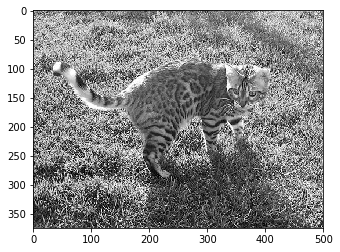

In [8]:
original_image = plt.imread('cat_grass.jpg') / 255
original_image = original_image.astype('float32')
plt.imshow(original_image*255, cmap = 'gray')

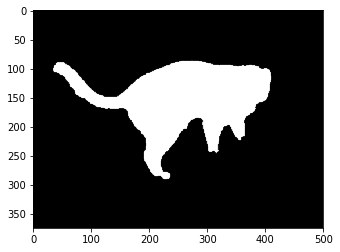

In [9]:
ground_truth = plt.imread('truth.png')  
plt.imshow(ground_truth, cmap = 'gray')

In [18]:
def g_x(x, param):
    diff = (x - param['mean'])
    return (param['log_prior_prob']
            - pi_term
            - param['log_det_cov']
            - (1/2) * np.dot(diff.T, np.dot(param['inv_cov'], diff)))[0, 0]

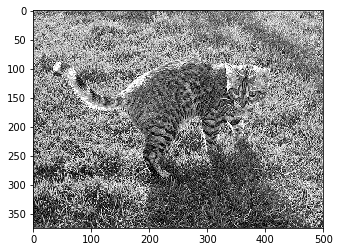

In [21]:
purturb_image = original_image.copy()
max_iteraton = 300
alpha = 0.001
lamb = 1
for iteration in range(max_iteraton):
    new_image = purturb_image.copy()
#     print(iteration)
    for i in range(original_image.shape[0]-8):
        for j in range(original_image.shape[1]-8):
#     for i in range(90, 120):
#         for j in range(50, 100):
            x_0 = original_image[i:i+8, j:j+8]
            x_0 = x_0.reshape((d, 1))
            x = purturb_image[i:i+8, j:j+8]
            x = x.reshape((d, 1))
            g = []
            for param in params:
                g.append(g_x(x, param))
            if g[0] > g[1]:
                continue
            else:
                gradient_value = 2*(x - x_0) + lamb*(np.dot(W, x) + w)
                new_x = x - alpha*gradient_value
                new_x = np.clip(new_x, 0, 1)
#                 if np.linalg.norm(new_x - x) > 0.01:
#                     new_image[i:i+8, j:j+8] = new_x.reshape((8, 8))
                new_image[i:i+8, j:j+8] = new_x.reshape((8, 8))
#             value = x.reshape((8, 8))
    #         value = cw_attack(x, 1, 0, params, 0.1).reshape((8, 8))
    
    if np.linalg.norm(new_image - purturb_image) < 0.01:
#         print(iteration)
        break
    else: 
        purturb_image = new_image.copy()
           
plt.imshow(purturb_image, cmap = 'gray')

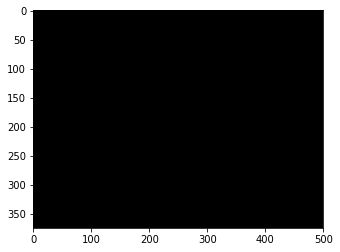

In [22]:
test = np.zeros((original_image.shape[0], original_image.shape[1]))
for i in range(purturb_image.shape[0]-8):
    for j in range(purturb_image.shape[1]-8):
        x = purturb_image[i:i+8, j:j+8]
        x = x.reshape((d, 1))
        g_glass = g_x(x, params[0])
        g_cat = g_x(x, params[1])
        
        if g_glass > g_cat:
            value = 0
        else:
            value = 1
        
        for m in range(8):
             for n in range(8):
                try:
                    test[i+m, j+n] = value
                except IndexError:
                    print(f'({i}+{m}, {j}+{n})')
plt.imshow(test, cmap = 'gray')
# plt.savefig("final_3_1_4.pdf") 

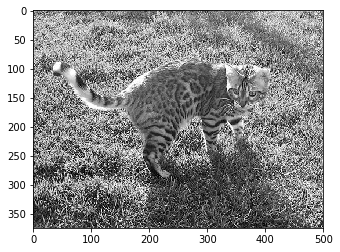

In [321]:
plt.imshow(original_image, cmap = 'gray')

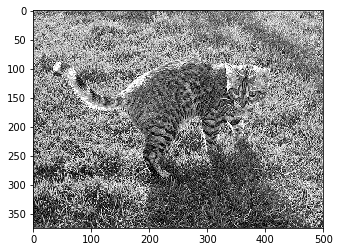

In [23]:
plt.imshow(purturb_image, cmap = 'gray')
plt.savefig("final_3_1_1.pdf") 

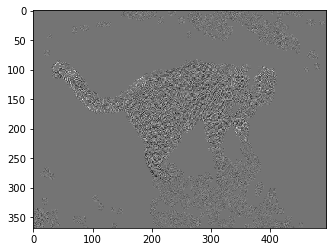

In [323]:
purturb = original_image[:368,:496]-purturb_image[:368,:496]
plt.imshow(purturb, cmap = 'gray')
plt.savefig("final_3_1_2.pdf") 

In [324]:
print(np.linalg.norm(purturb))

29.156866


In [38]:
def test_image(image):
    
    test = np.zeros((image.shape[0], image.shape[1]))
    for i in range(image.shape[0]-8):
        for j in range(image.shape[1]-8):
            x = image[i:i+8, j:j+8]
            x = x.reshape((d, 1))
            g_glass = g_x(x, params[0])
            g_cat = g_x(x, params[1])

            if g_glass > g_cat:
                value = 0
            else:
                value = 1

            for m in range(8):
                 for n in range(8):
                    try:
                        test[i+m, j+n] = value
                    except IndexError:
                        print(f'({i}+{m}, {j}+{n})')
    plt.imshow(test, cmap = 'gray')
    return test

In [37]:
def count_white(image):
    white_pixel = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] == 0:
                white_pixel += 1
    return white_pixel

In [36]:
count_white(test)

0

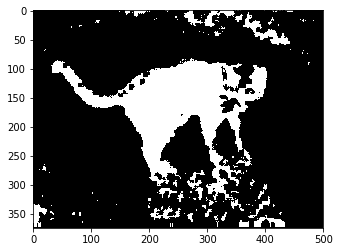

In [40]:
original_imag_test = test_image(original_image)

In [41]:
count_white(original_imag_test)

150722

In [279]:
defend = np.zeros((purturb_image.shape[0]-8, purturb_image.shape[1]-8))
for i in range(purturb_image.shape[0]-8):
    for j in range(purturb_image.shape[1]-8):
        x = purturb_image[i:i+8, j:j+8]
        x = x.reshape((d, 1))
        g_glass = g_x(x, params[0])
        g_cat = g_x(x, params[1])
        defend[i, j] = g_glass - g_cat

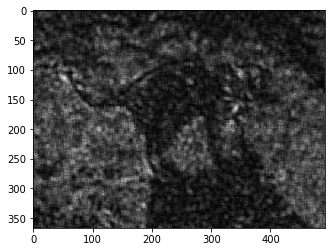

In [280]:
plt.imshow(defend, cmap = 'gray')
# plt.savefig("final_4_1.pdf") 

(array([6.000e+01, 1.780e+02, 3.310e+02, 6.260e+02, 9.490e+02, 1.374e+03,
        1.826e+03, 2.216e+03, 2.582e+03, 2.750e+03, 3.134e+03, 3.403e+03,
        3.529e+03, 3.716e+03, 3.845e+03, 3.954e+03, 3.859e+03, 3.950e+03,
        3.940e+03, 3.906e+03, 3.968e+03, 3.849e+03, 3.688e+03, 3.612e+03,
        3.586e+03, 3.571e+03, 3.385e+03, 3.338e+03, 3.358e+03, 3.204e+03,
        3.156e+03, 3.185e+03, 3.234e+03, 3.192e+03, 3.127e+03, 3.114e+03,
        3.071e+03, 3.005e+03, 2.922e+03, 2.954e+03, 2.769e+03, 2.771e+03,
        2.759e+03, 2.685e+03, 2.602e+03, 2.544e+03, 2.480e+03, 2.480e+03,
        2.376e+03, 2.310e+03, 2.140e+03, 2.183e+03, 2.090e+03, 1.913e+03,
        1.850e+03, 1.735e+03, 1.704e+03, 1.588e+03, 1.486e+03, 1.433e+03,
        1.394e+03, 1.269e+03, 1.249e+03, 1.178e+03, 1.042e+03, 1.038e+03,
        9.350e+02, 9.650e+02, 8.060e+02, 7.760e+02, 7.050e+02, 7.110e+02,
        6.320e+02, 5.630e+02, 5.560e+02, 4.720e+02, 4.580e+02, 4.650e+02,
        4.150e+02, 3.760e+02, 2.920e+0

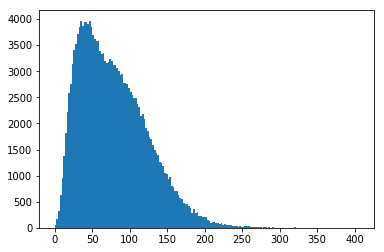

In [281]:
plt.hist(defend.flatten('F') , bins='auto')
# plt.savefig("final_4_2.pdf") 

In [282]:
defend[150:152, 200:205].flatten('F')

array([41.18600413, 40.78702429, 48.02206615, 21.95790349, 58.60149078,
       29.67261926, 42.87820833, 25.08880793, 24.44867289, 18.19586364])

In [283]:
np.mean(defend)

78.53530223483236

In [284]:
scipy.stats.mode(defend[150:152, 200:205].flatten('F'))

ModeResult(mode=array([18.19586364]), count=array([1]))

In [285]:
defend_mean = np.mean(defend)

In [286]:
q25 = np.percentile(defend, 25)
q25

42.7435270688847

In [287]:
def_std = np.std(defend)

In [288]:
mark_recover = np.zeros((defend.shape[0]-8, defend.shape[1]-8))
for i in range(defend.shape[0]-8):
    for j in range(defend.shape[1]-8):
        if defend[i, j] > q25:
            if np.mean(defend[i:i+8, j:j+8]) < q25 + def_std:
                mark_recover[i, j] = 1
            else:
                mark_recover[i, j] = 0
        else:
            mark_recover[i, j] = 1

76986

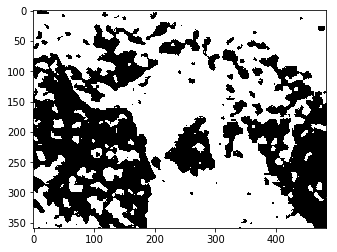

In [289]:
plt.imshow(mark_recover, cmap = 'gray')
# plt.savefig("final_4_3.pdf") 
count_white(mark_recover)

In [134]:
sum_patch_value = np.zeros((8, 8))
pixel_count = 0
for i in range(defend.shape[0]-8):
    for j in range(defend.shape[1]-8):
        if defend[i, j] > defend_mean:
            sum_patch_value = sum_patch_value + purturb_image[i:i+8, j:j+8]
            pixel_count += 1
mean_patch = (sum_patch_value/pixel_count).reshape((64, 1))

In [135]:
mean_patch-cat_mean

matrix([[0.07196111],
        [0.07530912],
        [0.07513699],
        [0.07765496],
        [0.08068771],
        [0.08354372],
        [0.07976817],
        [0.08223964],
        [0.06921123],
        [0.0738531 ],
        [0.073379  ],
        [0.07811047],
        [0.07844814],
        [0.08064911],
        [0.07803716],
        [0.0818149 ],
        [0.07099274],
        [0.07425689],
        [0.07719328],
        [0.0840615 ],
        [0.08078873],
        [0.08177942],
        [0.08412277],
        [0.08579112],
        [0.07246831],
        [0.07818597],
        [0.07749272],
        [0.08286714],
        [0.08091523],
        [0.08621078],
        [0.08338147],
        [0.08602346],
        [0.07400773],
        [0.07645445],
        [0.07512906],
        [0.08016705],
        [0.08295881],
        [0.08346446],
        [0.07953444],
        [0.08155442],
        [0.06914136],
        [0.07385191],
        [0.07503576],
        [0.08187165],
        [0.0782135 ],
        [0

In [214]:
add_back = (np.dot(W, mean_patch) + w).reshape((8, 8))
add_back

matrix([[-0.17170875, -0.39310465, -0.0364454 , -0.08158739, -0.11859931,
         -0.97289405,  0.42289218, -0.65916224],
        [ 0.229614  , -0.18953036,  0.570678  ,  0.25140672,  0.47270187,
         -0.21359414,  0.64857578,  0.1951321 ],
        [-0.09129072,  0.2124891 , -0.18838529, -0.61176097,  0.07406908,
          0.03349846,  0.01052705, -0.45326179],
        [-0.10589303, -0.45600096,  0.48080186, -0.52733362,  0.7439273 ,
         -0.41359435,  0.07346275, -0.30307177],
        [-0.13444008, -0.27910163,  0.13066017,  0.00763624, -0.2371874 ,
         -0.33407928,  0.41108549, -0.15216805],
        [ 0.51447906, -0.22371637,  0.84354815, -0.56453444,  1.0085208 ,
         -0.71218904,  0.86888151, -0.10352148],
        [-0.17728913, -0.03320586, -0.22456825, -0.35802154,  0.07745619,
          0.31968865, -0.33459948, -0.33610715],
        [-0.09084447, -0.49983315,  0.22578395, -0.36027762,  0.16970931,
         -0.51226958,  0.05281789, -0.51264303]])

In [226]:
restore_image = np.zeros((purturb_image.shape[0], purturb_image.shape[1]))
for i in range(original_image.shape[0]):
    if (i % 8) != 0 or i+8 >= purturb_image.shape[0]:
        continue
    for j in range(original_image.shape[1]):
        if (j % 8) != 0 or j+8 >= purturb_image.shape[1]:
            continue
        factor = defend[i, j] / defend_mean
        beta = 0.1
        restore_image[i:i+8, j:j+8] = purturb_image[i:i+8, j:j+8] + beta*factor*add_back

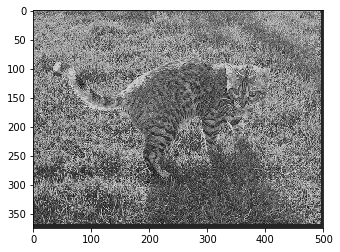

In [227]:
plt.imshow(restore_image, cmap = 'gray')

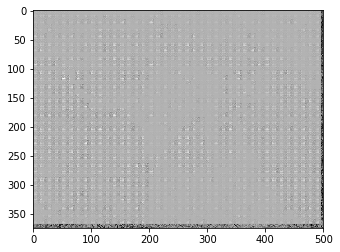

In [228]:
plt.imshow(restore_image-purturb_image, cmap = 'gray')

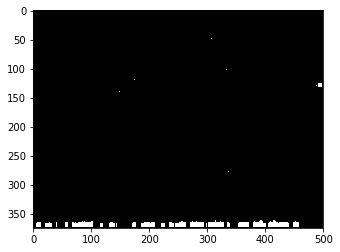

In [229]:
test = test_image(restore_image)

In [65]:
from skimage.restoration import denoise_wavelet

In [266]:
denoised_img = denoise_wavelet(purturb_image, sigma=0.1)

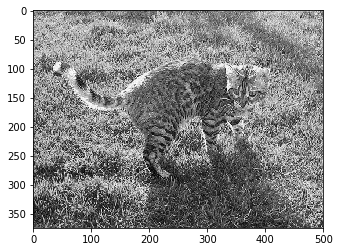

In [267]:
plt.imshow(denoised_img, cmap = 'gray')

In [268]:
denoised_img_original = denoise_wavelet(original_image, sigma=0.1)

35144

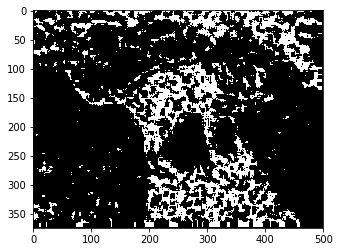

In [293]:
denoised_image_test = test_image(denoised_img)
plt.imshow(denoised_image_test, cmap = 'gray')
# plt.savefig("final_4_7.pdf") 
count_white(denoised_image_test)

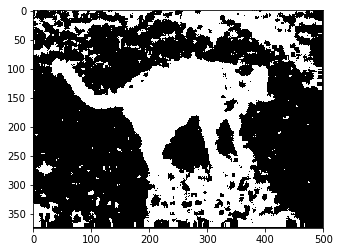

In [273]:
denoised_image_test_ori = test_image(denoised_img_original)

33384

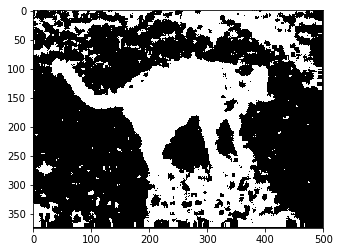

In [292]:
plt.imshow(denoised_image_test_ori, cmap = 'gray')
# plt.savefig("final_4_8.pdf") 
count_white(denoised_image_test_ori)

In [87]:
def pixel_deflection_without_map(img, deflections, window):
    img = np.copy(img)
    H, W = img.shape
    while deflections > 0:
        #for consistency, when we deflect the given pixel from all the three channels.
        x,y = randint(0,H-1), randint(0,W-1)
        while True: #this is to ensure that PD pixel lies inside the image
            a,b = randint(-1*window,window), randint(-1*window,window)
            if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
        # calling pixel deflection as pixel swap would be a misnomer,
        # as we can see below, it is one way copy
        img[x,y] = img[x+a,y+b] 
        deflections -= 1
    plt.imshow(img, cmap = 'gray')
    return img

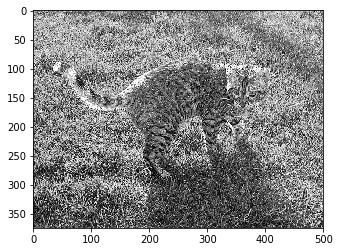

In [259]:
pd_purturb = pixel_deflection_without_map(purturb_image, deflections=24000, window=50)

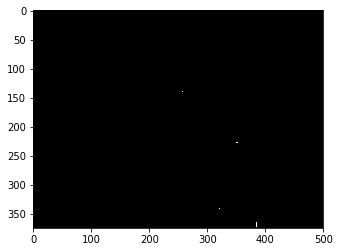

In [261]:
pd_result = test_image(pd_purturb)

36759

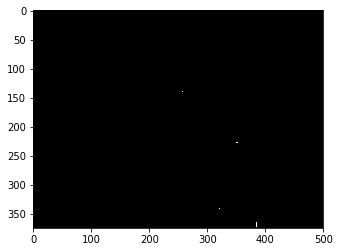

In [290]:
plt.imshow(pd_result, cmap = 'gray')
# plt.savefig("final_4_6.pdf") 
count_white(pd_result)

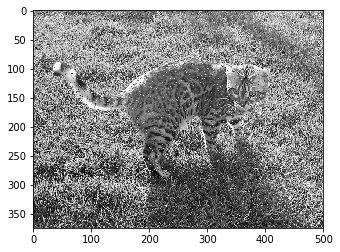

In [262]:
original_purturb = pixel_deflection_without_map(original_image, deflections=24000, window=50)

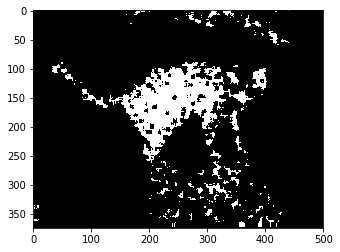

In [263]:
pd_result_ori = test_image(original_purturb)

17559

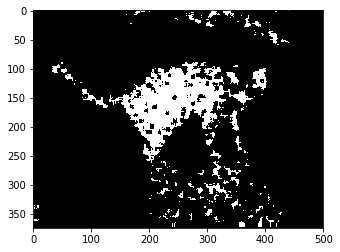

In [291]:
plt.imshow(pd_result_ori, cmap = 'gray')
# plt.savefig("final_4_5.pdf") 
count_white(pd_result_ori)

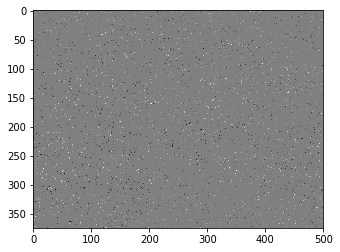

In [104]:
plt.imshow(pd_purturb-purturb_image, cmap = 'gray')

In [276]:
def count_white(image):
    white_pixel = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] != original_imag_test[i, j]:
                white_pixel += 1
    return white_pixel

In [277]:
count_white(original_imag_test)

0

In [ ]:
count_white(original_imag_test)